In [1]:
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from matplotlib import pyplot as plt

import tensorflow as tf
import pandas as pd
import numpy as np
import os

In [2]:
TEST_IMAGE_PATH = os.path.join("Data", "images_test")
TEST_MASK_PATH = os.path.join("Data", "masks_test")

DEF_HEIGHT, DEF_WIDTH = 768, 896
DES_HEIGHT, DES_WIDTH = 256, 256

DEF_SHAPE = (DEF_HEIGHT, DEF_WIDTH)
DES_SHAPE = (DES_HEIGHT, DES_WIDTH)

DEF_SHAPE_RGB = (*DEF_SHAPE, 3)
DES_SHAPE_RGB = (*DES_SHAPE, 3)

SCALE = True  # scale data from 0 to 1
FOCUS_PATCH = True  # crop to keep only patch parts of image
CHECKPOINT_PATH = "checkpoint.keras"
RESIZE_OPTIONS = {
    'mode': 'constant',
    'anti_aliasing': True,
    'preserve_range': True
}

In [3]:
def load_test_data():
    test_files = os.listdir(TEST_IMAGE_PATH)
    test_shape = (len(test_files), *DEF_SHAPE)
    test_images = np.empty((*test_shape, 3))
    test_masks = np.empty(test_shape)

    for i, test_file in enumerate(test_files):
        filename, ext = os.path.splitext(test_file)
        image_path = os.path.join(TEST_IMAGE_PATH, test_file)
        mask_path = os.path.join(TEST_MASK_PATH, filename.rstrip('_ccd')+ext)

        test_images[i] = imread(image_path)
        test_masks[i] = imread(mask_path)

    return test_images, test_masks

In [4]:
def preprocess(images, masks):
    new_images = np.empty((len(images), *DES_SHAPE_RGB))
    new_masks = np.empty((len(masks), *DES_SHAPE))

    for i in range(len(images)):
        image = images[i]
        mask = masks[i]

        if FOCUS_PATCH:
            y_coord, x_coord = np.where(mask == 255)
            y_slice = slice(y_coord.min(), y_coord.max())
            x_slice = slice(x_coord.min(), x_coord.max())
            image = image[y_slice, x_slice]
            mask = mask[y_slice, x_slice]

        if SCALE:
            image = image / 255
            mask = mask /255

        new_images[i] = resize(image, DES_SHAPE_RGB, **RESIZE_OPTIONS)
        new_masks[i] = resize(mask, DES_SHAPE, **RESIZE_OPTIONS)

    return new_images, new_masks

In [5]:
test_images, test_masks = load_test_data()

In [6]:
test_X, test_M = preprocess(test_images, test_masks)

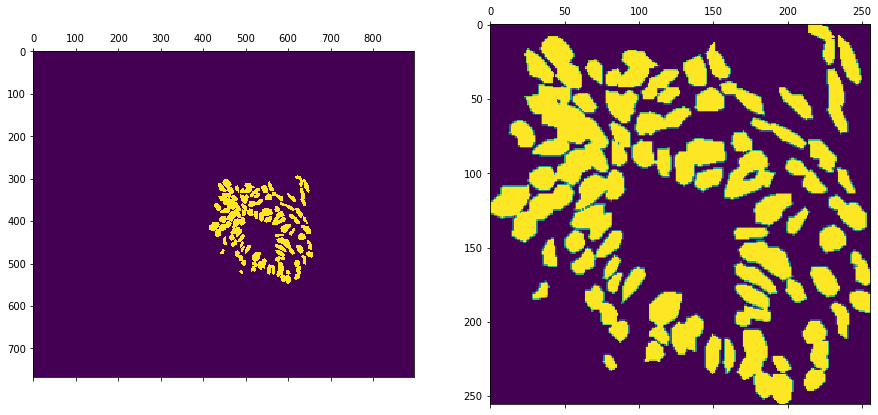

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.matshow(test_masks[0])
ax2.matshow(test_M[0])

In [9]:
model = tf.keras.models.load_model(CHECKPOINT_PATH)

In [10]:
predicted_masks = np.squeeze(model.predict(test_X))

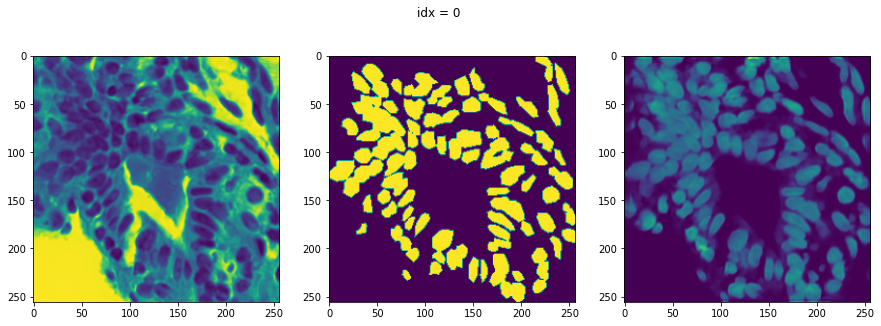

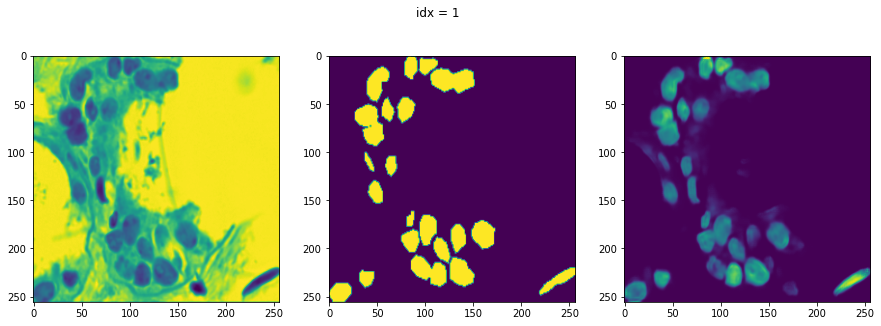

In [11]:
for i in range(len(test_X)):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.suptitle(f'idx = {i}')

    ax1.imshow(test_X[i][:, :, 1])
    ax2.imshow(test_M[i])
    ax3.imshow(predicted_masks[i])